# 成交量指标策略
*市场短期是投票机，长期是称重机*

## 目录
1. 什么是成交量？
2. 如何计算成交量指标？
3. 如何用图形展示成交量？
4. 如何用成交量指标来编写策略？

## 什么是成交量？

成交量有三种可能，分别是量增、量减、量平。 

价格也有三种可能，分别是上涨、下跌、横盘。

量价理论表明价涨量增是上涨趋势的确认，反之价跌量增是下跌趋势的确认。

## 如何计算成交量指标？
---
### 1. ADV-平均成交量
$MA(volume,20)$

---

### 2. OBV
OBV属于市场的领先指标，计算方法是如果当天价格高于前一天的价格，当天成交量就用加的，反之就用减的来计算出OBV指标，这样有助于分析成交量与价格的关系。

---

### 3. A/D
A/D 指标在OBV的基础上对价格的波幅进行了计算，真实波幅越大，指标中的成交量占比越大。

$\frac{A}{D}=\frac{Close-Open}{High-Low}*Volume$

---

### 4. WVAP
按成交量来衡量价格的权重，成交量越大价格权重越大。

$sum(close * volume, 20)/sum(volume, 20)$

## 如何用图形展示成交量？

In [1]:
from jaqs.data import DataView
from jaqs.data import RemoteDataService
import os
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

dataview_folder = 'JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [6]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df

close = change_index(dv.get_ts('close_adj').loc[20170105:])
volume = change_index(dv.get_ts('volume').loc[20170105:])

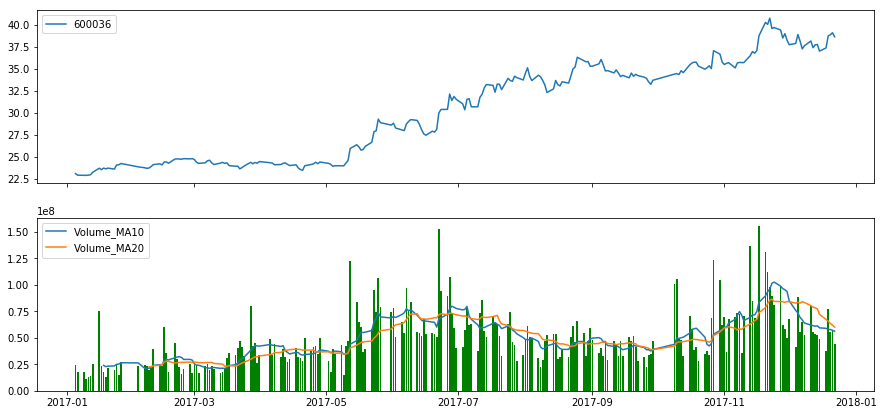

In [8]:
adv10 = ta.abstract.MA(volume, 10, price='600036.SH')
adv20 = ta.abstract.MA(volume, 20, price='600036.SH')

fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(15,7))
ax.plot(close['600036.SH'], label='600036')
ax.legend(loc='upper left')
ax1.bar(volume.index, volume['600036.SH'],color='g')
ax1.plot(adv10, label='Volume_MA10')
ax1.plot(adv20, label='Volume_MA20')
plt.legend(loc='upper left')
plt.show()

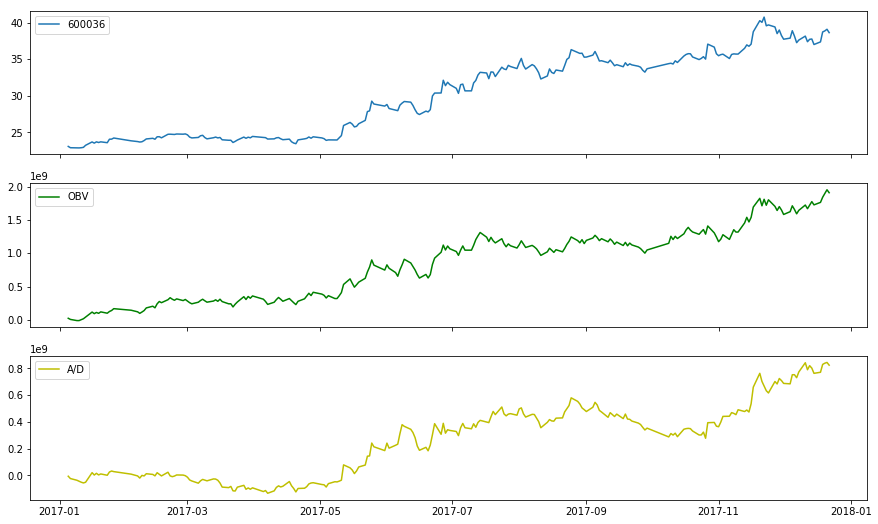

In [16]:
#OBV & A/D
Close = close['600036.SH'].values
Volume = volume['600036.SH'].values
Low = change_index(dv.get_ts('low_adj').loc[20170105:])['600036.SH'].values
High = change_index(dv.get_ts('high_adj').loc[20170105:])['600036.SH'].values


OBV = pd.Series(ta.OBV(Close, Volume), index=close.index)
AD = pd.Series(ta.AD(High, Low, Close, Volume), index=close.index)

fig, (ax, ax1,ax2) = plt.subplots(3, 1, sharex=True, figsize=(15,9))
ax.plot(close['600036.SH'], label='600036')
ax.legend(loc='upper left')
ax1.plot(OBV,'g', label='OBV')
ax1.legend(loc='upper left')
ax2.plot(AD, 'y', label='A/D')
ax2.legend(loc='upper left')
plt.show()

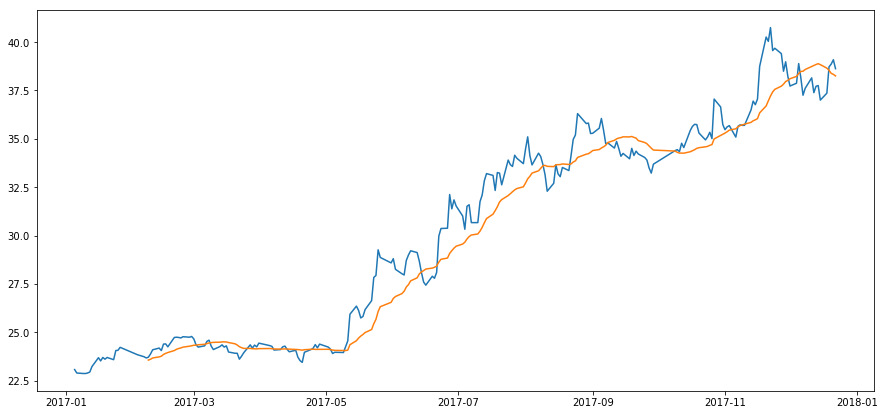

In [31]:
def ts_sum(ts, window=20):
    return ts.rolling(window).sum()

VWAP = ts_sum(pd.Series(Volume,index=volume.index)*close['600036.SH'])/ts_sum(pd.Series(Volume,index=volume.index))

plt.figure(figsize=(15,7))
plt.plot(close['600036.SH'])
plt.plot(VWAP)
plt.show()

## 如何用成交量指标来编写策略？
### VWAP策略
买入：

close>VWAP

卖出：

close<VWAP


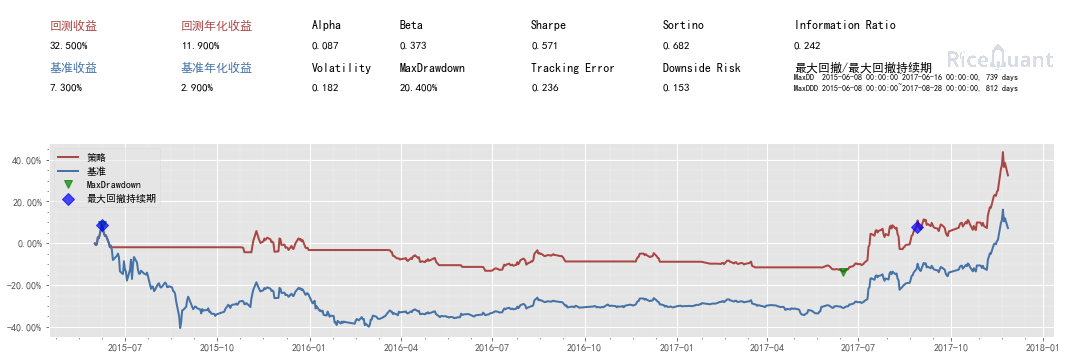

{'sys_analyser': {'benchmark_portfolio':                  cash  market_value  static_unit_net_value  total_value  \
  date                                                                      
  2015-06-01      1.300    999998.700                  1.000  1000000.000   
  2015-06-02      1.300    991822.610                  1.000   991823.910   
  2015-06-03      1.300    995596.190                  0.992   995597.490   
  2015-06-04      1.300   1029558.410                  0.996  1029559.710   
  2015-06-05      1.300   1025155.900                  1.030  1025157.200   
  2015-06-08      1.300   1087419.970                  1.025  1087421.270   
  2015-06-09      1.300   1067923.140                  1.087  1067924.440   
  2015-06-10      1.300   1049055.240                  1.068  1049056.540   
  2015-06-11      1.300   1036476.640                  1.049  1036477.940   
  2015-06-12      1.300   1038363.430                  1.036  1038364.730   
  2015-06-15      1.300   1001256.560

In [36]:
#VWAP

import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.PERIOD = 60


def handle_bar(context, bar_dict):

    price = history_bars(context.s1, context.PERIOD+1, '1d', 'close')
    volume = history_bars(context.s1, context.PERIOD+1, '1d', 'volume')
    denominator = price*volume
    
    VWAP = talib.SUM(denominator,context.PERIOD)/talib.SUM(volume,context.PERIOD)

    cur_position = context.portfolio.positions[context.s1].quantity
    shares = context.portfolio.cash/bar_dict[context.s1].close

    if price[-1] < VWAP[-1] and cur_position > 0:
        order_target_value(context.s1, 0)

    if price[-1] > VWAP[-1]:
        order_shares(context.s1, shares)

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2017-12-01",
    "accounts": {'stock':1000000},
    "benchmark": "000001.XSHE"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

## 作业
参考以上代码用其他成交量指标做策略